# Decision Tree Lab

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import math

## 1. (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  
### Code Requirements/Notes:
- Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits. Otherwise, even with approaches like pruning below, the SSE type of overfit could still hurt us.) 
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use a simple data set (like the lenses data or the pizza homework), which you can check by hand, to test your algorithm to make sure that it is working correctly. 

In [27]:
# THIS WAS NOT USED BUT WAS A PROTOTYPE
class Node():
    children = []
    value = None
    def __init__(self, parent=None, globalData=None):
        self.parent = parent
        self.value = None
        self.globalData = globalData
        if parent == None:
            self.children = []

    def id320(self, value_counts, counts, splitNodes=[]):
        print('theCounts: ', counts)
        print('splitNodes: ', splitNodes)


        # 2 If there is only one class type in that tree (i.e. it's pure)
        isPure, classification = self.checkIfPure(value_counts)
        if isPure:
            # set a new child node for terminal state
            #value_counts = [[], value_counts[self.value]]
            terminalNode = Node(self)
            terminalNode.value = classification
            self.children.append(terminalNode)
            print('returning because pure')
            return

        # 1 STOPPING CRITERIA, if len(splitNodes) == len(counts)
        if len(splitNodes) == len(counts)-1:
            print('parent globlD: ', self.parent.globalData)
            classification = self.getMaxClass(self.parent.globalData)
            print('maxClass: ', classification)
            terminalNode = Node(self)
            terminalNode.value = classification
            self.children.append(terminalNode)
            print('leaving because len(split) was same as len(counts)-1')
            return

        

        # 3 If node is empty

        # VALUE_COUNTS USAGE: first dimention, is for what feature, second dimention is for
        # the subset, and third dimention is for individual value. The final individual value is the target
        print('VC: ', value_counts)

        final_info = []
        #print('run for: ', len(value_counts))
        for feature in range(len(value_counts)):
            temp = 0
            #if feature not in splitNodes:
            #print('tick')
            sizeS = 0
            
            for subsection in value_counts[feature]:
                sizeS += len(subsection)

            for subsection in value_counts[feature]:
                # COULD RUN INTO THE ISSUE OF SUBSECTION BEING LEN(0)
                if len(subsection) > 0:
                    #print('subs/x: {x}/{y}'.format(x=len(subsection), y=sizeS))
                    scalar = len(subsection) / sizeS
                    info_sub = self.calculateInfo(subsection, counts[len(counts)-1], splitNodes)
                    #print('info_sub: ', info_sub)
                    temp += scalar * info_sub
            final_info.append(temp) 
            #else:
                #final_info.append(10000)
                # feature -= 1
        #if len(final_info) == 1:
            #print('returned because final_info was len 1')
            #return

        print('final_info: ', final_info)
        splitIndex = final_info.index(min(final_info))
        
        # NEED TO DO SOME MAGIC HERE
        countsCOPY = counts.copy()
        findTheIndex = 0
        finalSplitIndex = splitIndex
        for cnt in range(len(countsCOPY)):
            if cnt in splitNodes:
                findTheIndex += 1

        finalSplitIndex += findTheIndex

        print('/FEATURE_TO_SPLIT_ON: ', finalSplitIndex)
        rangeToGo = counts[finalSplitIndex]
        splitNodes.append(finalSplitIndex)


        # print('rangeToGo: ', rangeToGo) 
        for i in range(rangeToGo):
            print('/starting side 0(l)1(r/c)2(r)etc.: ', i)
            print('valcnts: ', value_counts)
            print('i: ', i)
            print('splitIndex: ', splitIndex)
            print('val_cnt[splitIndex]: ', value_counts[splitIndex])
            print('using the value_count: ', value_counts[splitIndex][i])

            next_value_counts = self.splitSubset(value_counts, splitIndex, i, counts, splitNodes)
            print('nextValCnt: ', next_value_counts)
            childNode = Node(self)
            print('--------------- setting childNode{node}.value: {x} --------------'.format(node=i, x=i))
            childNode.value = i
            childNode.id320(next_value_counts, counts, splitNodes.copy())

            self.children.append(childNode)

    def getMaxClass(self, value_counts):
        targetList = []
        for feature in value_counts:
            targetList.append(feature[len(feature)-1])
        most_common_class = max(targetList, key= targetList.count)

        return most_common_class

    def checkIfPure(self, value_counts):
        # VALUE_COUNTS USAGE: first dimention, is for what feature, second dimention is for
        # the subset, and third dimention is for individual value. The final individual value is the target
        myset = set()
        for feature in value_counts:
            for subset in feature:
                #print(subset)
                for row in subset:
                    myset.add(row[len(row)-1])
                #myset.add(subset[len(subset)-1])

        if len(myset) == 1:
            return True, myset.pop
        else:
            return False, None

    def id3(self, X, y, counts):
        # ANOTHER STOPPING CRITERIA IS IF THERE IS ONLY ONE CLASS TYPE IN THAT TREE
        # NEED TO STORE WHAT THE CLASSIFICATION IS GOING TO BE AT THE LEAF NODE
        # print(X)
        # print(y)
        print('theCounts: ', counts)
        # STOPPING CRITERIA
        if len(counts) <= 1:
            print('returned because counts is <= 1')
            return

        # print(counts)
       
        # separate the features into sub sized sections to calculate (i.e. |Smeat=N|)

        # VALUE_COUNTS USAGE: first dimention, is for what feature, second dimention is for
        # the subset, and third dimention is for individual value
        print('lenOfCounts: ', len(counts))
        value_counts = []
        for col in range(len(counts)-1):
            temp = []
            for val in range(counts[col]):
                mysubset = self.getSubset(val, col, X.copy(), y.copy())
                if mysubset != []:
                    temp.append(mysubset)
            value_counts.append(temp)

        final_info = []
        #print('val_cnts: ', value_counts)
        for feature in value_counts:
            temp = 0
            print('feature: ', feature)
            for subsection in feature:
                # the length of my subsection is 0. 
                if len(subsection) == 0:
                    print('returned because subsection is len 0') #FIXME NEED TO FIGURE OUT WHY ON EARTH THESE SUBSECTIONS ARE len 0
                    return
                # |Sj|/|S|
                scalar = len(subsection) / len(X)
                # print('start calcInfo')
                info_sub = self.calculateInfo(subsection, counts[len(counts)-1])
                #print(info_sub)
                # print('end calcInfo')
                # STOPPING CRITERIA
                
                # print("FINISHED")
                temp += scalar * info_sub
            final_info.append(temp)

        print('final_info: ', final_info)
        if final_info == []:
            print('returned becaues of final_info being empty')
            return
        splitIndex = final_info.index(min(final_info))
        print('FEATURE TO SPLIT ON: ', splitIndex)

        rangeToGo = counts[splitIndex]
        counts2 = counts.copy()
        del counts2[splitIndex]
        #print('oldCounts: ', counts)
        #print('newCounts: ', counts2)

        for i in range(rangeToGo):
            # need to split the data into subsections
            print('starting side 0(l)1(r/c)2(r)etc.: ', i)
            print('valcnts: ', value_counts)
            print('using the value_count: ', value_counts[splitIndex][i])

            
            sub_X, sub_y = self.splitSubsetIntoXandY(value_counts[splitIndex][i], i)
            childNode = Node(self)
            childNode.id3(sub_X, sub_y, counts2)
            self.children.append(childNode)
            # print('children: ', str(self.children))
            
            
            
        #print(value_counts[0])
        #print(len(X))

        pass


    def calculateInfo(self, subsection, counts_targets, splitNodes):
        # MAKE SURE TO TIMES FINAL VALUE BY -1
        # print('subs: ', subsection)
        temp = []
        for targ in range(counts_targets):
            # 0, 1, 2
            temp2 = []
            for sec in range(len(subsection)):
                if subsection[sec][len(subsection[sec])-1] == targ: #and sec not in splitNodes:
                    temp2.append(subsection[sec])
            temp.append(temp2)

        # print('temp:', temp)
        info = 0
        for subs in temp:
            ratio = (len(subs) / len(subsection))
            # if ratio == 0, will need to not do math.log
            if ratio == 0:
                info += 0
            else:
                info += ratio * math.log(ratio, 2)
        info *= -1
        # print('INFO: ', info)
        return info

    def splitSubset(self, value_counts, sideToSplit, nodeSide, counts, splitNodes):
        # VALUE_COUNTS USAGE: first dimention, is for what feature, second dimention is for
        # the subset, and third dimention is for individual value. The final individual value is the target
        data = value_counts[sideToSplit][nodeSide].copy()
        print('subset: ', data) # [[0, 1, 0, 0], [0, 2, 1, 1], [0, 0, 1, 1], [0, 0, 0, 0]]
        self.globalData = data
        final = []
        # loop that goes 2
        
        for col in range(len(counts)-1):
            if col not in splitNodes:
                temp = []
                # loop that goes 3, then 2
                #print('col: ', col)
                for value in range(counts[col]): 
                    #print('value: ', value)
                    #temp.append([]) # NEED SOMETHING TO GO HERE\
                    temp.append(self.splitHelper(data, value, col))
                final.append(temp)
        #print('final: ', final)
        return final
        #temp = []
        #for item in range(len(data)):
        #    del data[item][sideToSplit]
        #    temp.append(data[item])
        # print('temp: ', temp) # [[1, 0, 0], [2, 1, 1], [0, 1, 1], [0, 0, 0]]
    def splitHelper(self, data, val, col):
        temp = []
        for row in data:
            #print('row: ', row)
            if row[col] == val:
                temp.append(row)
        return temp
    
        

In [2]:
class Node2():
    def __init__(self, parent=None):
        self.children = []
        self.parent = parent
        self.value = -1
        self.infoGains = []
        self.splitIndex = -1
    
    def id3(self, X, y, counts):
        # calculate the gain for each remaining attribute
        infoS = 0
        for attribute in range(counts[len(counts)-1]):
            # 0, 1, 2
            if len(X) != 0:
                ratio = self.countAttributes(y, attribute) / len(X)
            else:
                break
            if ratio != 0:
                infoS += -1 * ratio * math.log(ratio, 2)
            else:
                ratio = 0
            #print(ratio)
        #print('infoS: ', infoS)
        infoAttributes = []
        for attribute in range(len(counts)-1):
            # 0, 1, 2
            infoAtt = 0
            for attType in range(counts[attribute]):
                # 0, 1
                attCount = 0
                myList = []
                for row in range(len(X)):
                    if X[row][attribute] == attType:
                        myList.append(y[row])
                        attCount += 1
                
                theSet = self.getTypesInList(myList)
                numSumItems = len(theSet)
                #print('nsi: ', numSumItems)
                if len(X) != 0:
                    theRatio = attCount/len(X)
                else:
                    break

                attSum = 0
                #print('{x}/{z} * '.format(x=attCount, z=len(X)))
                while(len(theSet) != 0):    
                    temporary = theSet.pop()
                    attSum += -1 * (myList.count(temporary)/attCount) * math.log(myList.count(temporary)/attCount, 2)
                    #print('-1 * ({x}/{y}) * log({x}/{y})'.format(x=myList.count(temporary), y=attCount))
                infoAtt += theRatio * attSum
                #print(infoAtt)
                # print('attribute:{x}, attType:{y}, attCount:{z}'.format(x=attribute, y=attType, z=attCount))
                
                #print(myList)
                
                #ratio = attCount / len(X)
            #print(infoAtt)
            #print(infoS - infoAtt)
            infoAttributes.append(infoS - infoAtt)
            #print('\n\n')
        #print(infoAttributes)
        
        if (max(infoAttributes)) == 0:
            self.infoGains = 1.0
            #print('returning because it is PURE!!')

            #WHAT TO DO IF IT'S PURE?? <----------------
            #print('X: ', X)
            #print('y: ', y)
            #print(self.value)

            child = Node2(self)
            #print('y: ', y)
            """if len(y) > 0:
                print('THIS IS THE CHILD VALUE: ', self.value)
                child.value = 1
            else:
                print('THIS IS THE CHILD VALUE: ', self.value)
                child.value = 1"""
            child.value = 1.0
            self.children.append(child)
            return
        self.infoGains = max(infoAttributes)
        splitIndex = np.argmax(infoAttributes)
        #print('SPLIT BEING MADE ON: ', splitIndex)
        self.splitIndex = splitIndex
        
        for numSplits in range(counts[splitIndex]):
            child = Node2(self)
            child.value = numSplits
            # need a new X and y
            childX = []
            childY = []
            for row in range(len(X)):
                if X[row][splitIndex] == numSplits:
                    childX.append(X[row])
                    childY.append(y[row])
            child.id3(childX, childY, counts)
            self.children.append(child)
        pass

    def printTree(self):
        myString = 'start: '
        for child in self.children:
            myString += 'sI'
            myString += str(self.splitIndex)
            myString += ':sv'
            myString += str(self.value)
            myString += '>'
            myString += 'cv'
            myString += str(child.value)
            myString += ' '
            child.printTree()
        print(myString)

    def getTypesInList(self, myList):
        numTypes = 0
        theSet = set()
        for item in myList:
            theSet.add(item)
        return theSet

    def countAttributes(self, y, attribute):
        sum = 0
        for item in y:
            if item == attribute:
                sum+=1
        return sum



In [3]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self,counts=None):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """
        self.counts = counts
    
    def getSubset(self, value, column, X, y):
        subset = []
        #print('X: ', X)
        #print('col: ', column)
        for item in range(len(X)):
            #print('X[i]: ', X[item])
            if X[item][column] == value:
                # print(X[item])
                mytemp = X[item].copy()
                mytemp.append(y[item])
                subset.append(mytemp)
        #print('getSubset:', subset)
        return subset

    def fit2(self, X, y):
        #print('START')
        #print('count fit2: ', self.counts)
        self.rootNode = Node2(None)
        self.rootNode.id3(X, y, self.counts)

        #print('END')
        return


    # THIS FUNCTION WAS NOT USED BUT WAS A PROTOTYPE
    def fit(self, X, y):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        
        print('START')
        # print(self.counts)
        # self.counts.pop()
        self.rootNode = Node(None)
        value_counts = []
        for col in range(len(self.counts)-1):
            temp = []
            for val in range(self.counts[col]):
                mysubset = self.getSubset(val, col, X.copy(), y.copy())
                if mysubset != []:
                    temp.append(mysubset)
            value_counts.append(temp)
        self.rootNode.globalData = value_counts
        self.rootNode.id320(value_counts=value_counts, counts=self.counts.copy())
        print('END')
            
        # need to create data splits of each of the feature types
        # i.e. need to have 3 sets if counts[0] = 3

        # then need to run ID3 on each feature, to determine the split.
        # make the split, rinse and repeat

        return self

    def predict(self, X):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        #values = []
        visited = []
        mySet = set()
        for x in X:
            pos = 0
            self.descend(self.rootNode, x, pos, visited, mySet)
        print('Info Gain Values: ', mySet)
        return visited

    def descend(self, currentNode, values, pos, visited, myset):
        #print('currNodeVal: ', currentNode.value)
        #print('values: ', values)
        #print('pos: ', pos)
        #print('currentNode.children: ', len(currentNode.children))
        #print('currentNode Info Gains: ', currentNode.infoGains)
        myset.add(currentNode.infoGains)
        if len(currentNode.children) == 1:
            #print('guessed: ', currentNode.children[0].value)
            visited.append(currentNode.children[0].value)
            return #currentNode.children[0].value
        if values[pos] >= len(currentNode.children):
            #print('guessed: ', currentNode.value)
            visited.append(currentNode.value)
            return #currentNode.value
        currentNode = currentNode.children[int(values[pos])]
        if len(currentNode.children) == 0:
            #print('guessed: ', currentNode.value)
            visited.append(currentNode.value)
            return #currentNode.value
        
        
        pos += 1
        
        self.descend(currentNode, values, pos, visited, myset)

    def score(self, X, y):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        values = self.predict(X)
        sum = 0
        for val in range(len(values)):
            if y[val] == values[val]:
                sum += 1
        #print('values: ', values)
        #print('y: ', y)
        return sum / len(values)



## 1.1 Debug

Debug your model by training on the lenses dataset: [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff)

Test your model on the lenses test set: [Debug Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff)

Parameters:
(optional) counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)

---

Expected Results: Accuracy = [0.33]

Predictions should match this file: [Lenses Predictions](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv)

*NOTE: The [Lenses Prediction](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv) uses the following encoding: soft=2, hard=0, none=1. If your encoding is different, then your output will be different, but not necessarily incorrect.*

Split Information Gains (These do not need to be in this exact order):

[0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits should look like, and the corresponding child node predictions:

Decision Tree:
<pre>
feature_3 = 0:
	feature_2 = 0:
		feature_0 = 0:
			prediction: 2
		feature_0 = 1:
			feature_1 = 0:
				prediction: 2
			feature_1 = 1:
				prediction: 1
		feature_0 = 2:
			prediction: 2
	feature_2 = 1:
		feature_1 = 0:
			feature_0 = 0:
				prediction: 1
			feature_0 = 1:
				prediction: 1
			feature_0 = 2:
				prediction: 0
		feature_1 = 1:
			prediction: 0
feature_3 = 1:
	prediction: 1
</pre>

In [4]:
# Load debug training data 
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff --output lenses_data.arff
lenses_data = arff.loadarff('lenses_data.arff')
lenses_df = pd.DataFrame(lenses_data[0])

# convert data into str
for col in lenses_df:
    lenses_df[col] = lenses_df[col].str.decode("utf-8")

count = [] # final value is target column
# get number of each type feature count
for col in lenses_df:
    temp = set()
    for item in lenses_df[col]:
        temp.add(item)
        # print(item)
    count.append(len(temp))

# print('count: ', count)
# print(lenses_df.head())

custom_target_mapping = {'soft':2, 'none':1, 'hard':0}
custom_bool_mapping = {'no':0, 'yes':1}
custom_tear_mapping = {'reduced':0, 'normal':1}
custom_spect_mapping = {'myope':0, 'hypermetrope':1}
custom_age_mapping = {'young':0, 'pre_presbyopic':1, 'presbyopic':2}

lenses_df['contact_lenses'] = lenses_df['contact_lenses'].map(custom_target_mapping)
lenses_df['astigmatism'] = lenses_df['astigmatism'].map(custom_bool_mapping)
lenses_df['tear_prod_rate'] = lenses_df['tear_prod_rate'].map(custom_tear_mapping)
lenses_df['spectacle_prescrip'] = lenses_df['spectacle_prescrip'].map(custom_spect_mapping)
lenses_df['age'] = lenses_df['age'].map(custom_age_mapping)
#print(lenses_df)

lenses_np = lenses_df.to_numpy()
lenses_np = lenses_np.astype(float)
lenses_np = lenses_np.tolist()

X = []
y = []
for data in lenses_np:
    X.append(data[0:len(data)-1])
    y.append(data[len(data)-1])
#print(lenses_np)
#print('X: ', X)
#print('y: ', y)

# no:0, yes:1
# thin:0, deep:1, stuffed:2
# no:0, yes:1
# bad:0, good:1, great:2
X_pizza = [[1, 0, 0], [0, 1, 0], [0, 2, 1], [1, 2, 1], [1, 1, 0], [1, 1, 1], [0, 0, 1], [1, 1, 0], [0, 0, 0]]
y_pizza = [2, 0, 1, 2, 1, 2, 1, 1, 0]
count_pizza = [2, 3, 2, 3]
#print('cnt: ', count)
decision_tree = DTClassifier(counts=count)
# Train Decision Tree
decision_tree.fit2(X, y)

# Load debug test data


# Predict and compute model accuracy
print('score: ', decision_tree.score(X,y))
# Print the information gain of every split you make.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2890  100  2890    0     0  10946      0 --:--:-- --:--:-- --:--:-- 10946
Info Gain Values:  {0.5487949406953985, 1.0, 0.3166890883150208, 0.7704260414863778, 0.4591479170272448, 0.9182958340544896}
score:  0.375


In [256]:
# [0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]
# Optional/Additional Debugging Dataset - Pizza Homework
# pizza_dataset = np.array([[1,2,0],[0,0,0],[0,1,1],[1,1,1],[1,0,0],[1,0,1],[0,2,1],[1,0,0],[0,2,0]])
# pizza_labels = np.array([2,0,1,2,1,2,1,1,0])

## 1.2 Evaluation

We will evaluate your model based on its performance on the zoo dataset. 

Train your model using this dataset: [Evaluation Train Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff)

Test your model on this dataset: [Evaluation Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff)

Parameters:
(optional) counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)

---
Print out your accuracy on the evaluation test dataset.

Print out the information gain of every split you make.

In [5]:
# Load evaluation training data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff --output eval_data.arff
eval_data = arff.loadarff('eval_data.arff')
eval_df = pd.DataFrame(eval_data[0])

# convert data into str
for col in eval_df:
    eval_df[col] = eval_df[col].str.decode("utf-8")

count = [] # final value is target column
# get number of each type feature count
for col in eval_df:
    temp = set()
    for item in eval_df[col]:
        temp.add(item)
        # print(item)
    count.append(len(temp))

# print('count: ', count)
# print(lenses_df.head())

#custom_target_mapping = {'soft':2, 'none':1, 'hard':0}
custom_bool_mapping = {'F':0, 'T':1}
custom_type_mapping = {'c6':0, 'c7':1, 'c5':2, 'cT':3, 'c4':4, 'c3':5, 'c2':6}
#custom_tear_mapping = {'reduced':0, 'normal':1}
#custom_spect_mapping = {'myope':0, 'hypermetrope':1}
#custom_age_mapping = {'young':0, 'pre_presbyopic':1, 'presbyopic':2}

eval_df['hair'] = eval_df['hair'].map(custom_bool_mapping)
eval_df['feathers'] = eval_df['feathers'].map(custom_bool_mapping)
eval_df['eggs'] = eval_df['eggs'].map(custom_bool_mapping)
eval_df['milk'] = eval_df['milk'].map(custom_bool_mapping)
eval_df['airborne'] = eval_df['airborne'].map(custom_bool_mapping)
eval_df['predator'] = eval_df['predator'].map(custom_bool_mapping)
eval_df['aquatic'] = eval_df['aquatic'].map(custom_bool_mapping)
eval_df['toothed'] = eval_df['toothed'].map(custom_bool_mapping)
eval_df['backbone'] = eval_df['backbone'].map(custom_bool_mapping)
eval_df['breathes'] = eval_df['breathes'].map(custom_bool_mapping)
eval_df['venomous'] = eval_df['venomous'].map(custom_bool_mapping)
eval_df['fins'] = eval_df['fins'].map(custom_bool_mapping)
eval_df['tails'] = eval_df['tails'].map(custom_bool_mapping)
eval_df['domestic'] = eval_df['domestic'].map(custom_bool_mapping)
eval_df['catsize'] = eval_df['catsize'].map(custom_bool_mapping)

eval_df['type'] = eval_df['type'].map(custom_type_mapping)
#print(eval_df.head())

#mySet = set()
#for item in eval_df['type']:
    #mySet.add(item)

#print(mySet)


eval_np = eval_df.to_numpy()
eval_np = eval_np.astype(float)
eval_np = eval_np.tolist()
# print(eval_np)

X_eval = []
y_eval = []
for data in eval_np:
    X_eval.append(data[0:len(data)-1])
    y_eval.append(data[len(data)-1])

#print('x: ',X_eval)
#print('y: ',y_eval)
# Train Decision Tree
eval_tree = DTClassifier(counts=count)
eval_tree.fit2(X_eval, y_eval)

# Load evaluation test data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff --output eval_test.arff
eval_test = arff.loadarff('eval_test.arff')
eval_df = pd.DataFrame(eval_test[0])

# convert data into str
for col in eval_df:
    eval_df[col] = eval_df[col].str.decode("utf-8")

count = [] # final value is target column
# get number of each type feature count
for col in eval_df:
    temp = set()
    for item in eval_df[col]:
        temp.add(item)
        # print(item)
    count.append(len(temp))

eval_df['hair'] = eval_df['hair'].map(custom_bool_mapping)
eval_df['feathers'] = eval_df['feathers'].map(custom_bool_mapping)
eval_df['eggs'] = eval_df['eggs'].map(custom_bool_mapping)
eval_df['milk'] = eval_df['milk'].map(custom_bool_mapping)
eval_df['airborne'] = eval_df['airborne'].map(custom_bool_mapping)
eval_df['predator'] = eval_df['predator'].map(custom_bool_mapping)
eval_df['aquatic'] = eval_df['aquatic'].map(custom_bool_mapping)
eval_df['toothed'] = eval_df['toothed'].map(custom_bool_mapping)
eval_df['backbone'] = eval_df['backbone'].map(custom_bool_mapping)
eval_df['breathes'] = eval_df['breathes'].map(custom_bool_mapping)
eval_df['venomous'] = eval_df['venomous'].map(custom_bool_mapping)
eval_df['fins'] = eval_df['fins'].map(custom_bool_mapping)
eval_df['tails'] = eval_df['tails'].map(custom_bool_mapping)
eval_df['domestic'] = eval_df['domestic'].map(custom_bool_mapping)
eval_df['catsize'] = eval_df['catsize'].map(custom_bool_mapping)

eval_df['type'] = eval_df['type'].map(custom_type_mapping)

eval_np = eval_df.to_numpy()
eval_np = eval_np.astype(float)
eval_np = eval_np.tolist()
# print(eval_np)

X_eval = []
y_eval = []
for data in eval_np:
    X_eval.append(data[0:len(data)-1])
    y_eval.append(data[len(data)-1])

# Print out the information gain for every split you make
print('score: ', eval_tree.score(X_eval, y_eval))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6683  100  6683    0     0  24126      0 --:--:-- --:--:-- --:--:-- 24126
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  171k  100  171k    0     0   498k      0 --:--:-- --:--:-- --:--:--  498k
Info Gain Values:  {0.8865408928220899, 1.4345249323507079, 0.6962122601251458, 0.9852281360342516, 1.0}
score:  0.1466


## 2. (20%) You will use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criteria, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, report the training and test classification accuracy for each fold and the average test accuracy. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

## 2.1 Implement 10-fold Cross Validation

In [6]:
# Write a function that implements 10-fold cross validation
def cross_validation(input):
    np.random.shuffle(input)

    n = 10
    d = len(input)
    partitions = d//n

    #print(partitions)
    
    datasets = []
    for i in range(n):
        #print(input[0])
        subset = []
        while(len(subset) < partitions):
            subset.append(input[0])
            np.random.shuffle(input)
        datasets.append(subset)
    #print(datasets)
    return datasets


##  2.2 Cars Dataset
- Use this [Cars Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff)
- Make a table for your K-Fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [8]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff --output cars_data.arff
cars_data = arff.loadarff('cars_data.arff')
cars_df = pd.DataFrame(cars_data[0])

# convert data into str
for col in cars_df:
    cars_df[col] = cars_df[col].str.decode("utf-8")

#print(cars_df)
count = []
theVals = []
for col in cars_df:
    temp = set()
    for item in cars_df[col]:
        temp.add(item)
        # print(item)
    theVals.append(temp)
    count.append(len(temp))
#print(count)
#print(theVals)

feature1_mapping = {'high':2, 'low':0, 'vhigh':3, 'med':1}
feature2_mapping = {'high':2, 'low':0, 'vhigh':3, 'med':1}
feature3_mapping = {'5more':3, '4':2, '2':0, '3':1}
feature4_mapping = {'4':1, '2':0, 'more':2}
feature5_mapping = {'big':2, 'small':0, 'med':1}
feature6_mapping = {'med':1, 'high':2, 'low':0}
feature7_mapping = {'unacc':0, 'acc':1, 'good':2, 'vgood':3}

cars_df['buying'] = cars_df['buying'].map(feature1_mapping)
cars_df['maint'] = cars_df['maint'].map(feature2_mapping)
cars_df['doors'] = cars_df['doors'].map(feature3_mapping)
cars_df['persons'] = cars_df['persons'].map(feature4_mapping)
cars_df['lug_boot'] = cars_df['lug_boot'].map(feature5_mapping)
cars_df['safety'] = cars_df['safety'].map(feature6_mapping)
cars_df['class'] = cars_df['class'].map(feature7_mapping)

cars_np = cars_df.to_numpy()
#print(cars_np[0])
cars_np = cars_np.tolist()
#print(cars_np[0])

# Use 10-fold CV on Cars Dataset
datasets = cross_validation(cars_np)
#print('DATASETS: ', datasets)
# Report Training and Test Classification Accuracies
# should be 10
scores = []
temp_model = None
for subset in datasets:
    dtc_cars = DTClassifier(counts=count)
    X_subset = []
    y_subset = []
    for row in subset:
        X_subset.append(row[0:len(row)-1])
        y_subset.append(row[len(row)-1])

    #print('\n\nX:', X_subset)
    dtc_cars.fit2(X_subset, y_subset)
    scores.append(dtc_cars.score(X_subset, y_subset))
    temp_model = dtc_cars

theSum = sum(scores)
theSum /= len(scores)

# Report Average Test Accuracy
print('Average Test Accuracy: ', theSum)
print(temp_model.rootNode.printTree())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55393  100 55393    0     0   277k      0 --:--:-- --:--:-- --:--:--  277k
Info Gain Values:  {0.26203210106937025, 1.0, 0.9709505944546686, 0.8240815653078634, 0.6335589401747911, 0.509185925460812, 0.5916727785823275, 0.6500224216483541, 0.6421837736369078, 0.7870317965313063, 0.9182958340544896, 0.8631205685666312, 0.7219280948873623, 0.5849625007211563, 0.8112781244591328, 0.9709505944546687}
Info Gain Values:  {0.3112051607838864, 0.3227799913351709, 0.6128118639862323, 0.5576620987735124, 1.0, 0.9852281360342516, 0.4236544199255302, 0.9910760598382222, 0.9254040749166412, 1.0455455038018957, 0.9182958340544896, 0.6500224216483541, 0.7219280948873623, 0.9709505944546686, 0.5849625007211563, 0.6213556175045353}
Info Gain Values:  {0.30069543083215955, 0.3437438655949272, 0.40584491736909667, 1.0, 0.5032583347756457, 1.4591

## 2.3 Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Note that you will need to support unknown attributes in the voting data set. 

In [9]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting_data.arff
voting_data = arff.loadarff('voting_data.arff')
voting_df = pd.DataFrame(voting_data[0])

# convert data into str
for col in voting_df:
    voting_df[col] = voting_df[col].str.decode("utf-8")

#print(cars_df)
count = []
theVals = []
for col in voting_df:
    temp = set()
    for item in voting_df[col]:
        temp.add(item)
        # print(item)
    theVals.append(temp)
    count.append(len(temp))
print(count)
print(theVals)



voting_mapping = {'n':0, 'y':1, '?':2}
voting_class_mapping = {'democrat':0, 'republican':1}

for feature in voting_df:
    if feature != 'Class':
        voting_df[feature] = voting_df[feature].map(voting_mapping)
    else:
        voting_df[feature] = voting_df[feature].map(voting_class_mapping)

#print(voting_df.head())
voting_np = voting_df.to_numpy()
#print(cars_np[0])
voting_np = voting_np.tolist()

# Used 10-fold CV on Voting Dataset
datasets = cross_validation(voting_np)

# Report Training and Test Classification Accuracies
scores = []
temp_model = None
for subset in datasets:
    dtc_voting = DTClassifier(counts=count)
    X_subset = []
    y_subset = []
    for row in subset:
        X_subset.append(row[0:len(row)-1])
        y_subset.append(row[len(row)-1])

    #print('\n\nX:', X_subset)
    dtc_voting.fit2(X_subset, y_subset)
    scores.append(dtc_voting.score(X_subset, y_subset))
    temp_model = dtc_voting

theSum = sum(scores)
theSum /= len(scores)

# Report Average Test Accuracy
print('Average Test Accuracy: ', theSum)
print(temp_model.rootNode.printTree())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40261  100 40261    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]
[{'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'n', '?', 'y'}, {'republican', 'democrat'}]
Info Gain Values:  {0.8512220455152237, 1.0, 0.19843231803921407}
Info Gain Values:  {0.7283919637722286, 1.0, 0.9182958340544896, 0.32253122003630347}
Info Gain Values:  {0.7716270663455436, 1.0, 0.4394969869215134}
Info Gain Values:  {0.8865136674523144, 1.0}
Info Gain Values:  {0.741599345763138, 0.5032583347756457, 1.0}
Info Gain Values:  {0.6700146676360692, 1.0, 0.4394969869215134}
Info Gain Values:  

## 2.4 Discuss Your Results

- Summarize your results from both datasets, and discuss what you observed. 
- A fully expanded tree will often get 100% accuracy on the training set. Why does this happen and in what cases might it not?  

Discuss your results -------------- The results that I saw from both datasets was that the decision tree model was much more accurate on the voting dataset rather than the cars dataset. My thinking behind this, is that decision tree's are better the more shallow that they are. I began to draw up the decision trees on a whiteboard, and the cars decision tree was much larger than the voting decision tree. I think that the number of output classes also greatly affects this, because it allows for exponentially growing trees! I think that the accuracy of 100% is often because with the training set it can expand so that each node becomes pure, and you more or less "memorize the dataset". Then once passed back in, you can easily follow your path. However, decision trees are not very good with generalization. I think that this causes the accuracy flaw when using the test data. I would say that this would not always occur in teh presense of unknown variables potentially? Or with many output classes, because the number of splits could cause the path to be hard to follow?

## 3. (15%) For each of the two problems above, summarize in English what the decision tree has learned (i.e. look at the induced tree and describe what rules it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

## 3.1 Discuss what the decision tree induced on the cars dataset has learned

Discussion Here -------------------- When I tried to draw out / display the graph, it was quite expansive. However there were a couple of things right off the bat that I noticed. The first split was made based off of the car's safety attribute. Which I thought was interesting, and if the car safety was high, it was later split on the number of persons it could carry. If the car was medium or low safety, it was split based upon the buying price which makes sense to me. It was also prevalent that the maintenance price was the final deciding factor which led to the greatest number of pure nodes following that split. I didn't follow the entire tree, because it was quite expansive, but it seemed to me that the decision tree learned some intuiton about the data.

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

Discussion Here ------------------- Is what my decision tree learned about the voting data, was that only two splits were required. I didn't expect the splits if I am being completely honest, but it was interesting to see. The first split is made upon the adoption-of-the-budget-resolution feature. It split it into 3 sections, if they voted no, yes, and if their vote was unknown. Both the no and unknown values were pure directions which I thought was interesting to see. Then if they adopted the budget resolution, another split was made that was on the feature water-project-cost-sharing. This too was split into 3 similar groups, all of which were pure nodes. So just based off of these two policies, it can somewhat confidently be determined the house of the politician. It is interesting that both of these features have something to do with money. Might be telling us something haha.

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

Discuss how you handled unknown attributes -------------------- I handled unknown values in the voting database by setting them all equal to an arbitrary value. I felt that this was appropriate because sometimes the lack of knowledge can be important. And it seems to me that this helped my decision tree algorithm split up the data in a way that made it more accurate with minimal amounts of splits!

## 4.1 (10%) Use SciKit Learn's decision tree on the voting dataset and compare your results. Try different parameters and report what parameters perform the best on the test set. 

### 4.1.1 SK Learn on Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)

In [10]:
# Use SK Learn's Decision Tree to learn the voting dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting_data.arff
voting_data = arff.loadarff('voting_data.arff')
voting_df = pd.DataFrame(voting_data[0])
#print(voting_df.head())
custom_mapping = {'?':-1, 'n':0, 'y':1}
custom_party_mapping = {'democrat':0, 'republican':1}
for feature in voting_df:
    voting_df[feature] = voting_df[feature].str.decode("utf-8")
    if feature != 'Class':
        voting_df[feature] = voting_df[feature].map(custom_mapping)
    else:
        voting_df[feature] = voting_df[feature].map(custom_party_mapping)
#print(voting_df.head()) 
voting_np = voting_df.to_numpy()
voting_np = voting_np.astype(float)
voting_np = voting_np.tolist()

X_vote = []
y_vote = []

for item in voting_np:
    X_vote.append(item[0:len(item)-1])
    y_vote.append(item[len(item)-1])

print(len(X_vote))
# criterion: entropy/gini
# splitter: best/random
# Explore different parameters
dtc = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=10, random_state=0)
dtc.fit(X_vote[0:400], y_vote[0:400])

print(dtc.score(X_vote[400:], y_vote[400:]))
print(dtc.get_depth())

# Report results

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40261  100 40261    0     0   276k      0 --:--:-- --:--:-- --:--:--  276k
435
0.9714285714285714
8


Discuss results & compare to your method's results ---------------- It seems to me that the accuracy of this decision tree is much greater than my decision tree, however my method is able to do it in much less depths. So that's the primary tradeoff i'm sure. It could also be due to how I handled missing data, or some potential corner cases. But my model performed about half as well, but with a third of the node expansions

## 4.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the SK decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [11]:
from sklearn.datasets import load_wine
# Use SciKit Learn's Decision Tree on a new dataset
wine = load_wine()
# print(wine.data)
dtc_wine = DecisionTreeClassifier()
dtc_wine.fit(wine.data, wine.target)

print(dtc_wine.score(wine.data, wine.target))
print(dtc_wine.get_depth())

# Experiment with different hyper-parameters
dtc_wine2 = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=2, random_state=0)
dtc_wine2.fit(wine.data, wine.target)

print(dtc_wine2.score(wine.data, wine.target))
print(dtc_wine2.get_depth())

dtc_wine3 = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=2, random_state=0)
dtc_wine3.fit(wine.data, wine.target)

print(dtc_wine3.score(wine.data, wine.target))
print(dtc_wine3.get_depth())

dtc_wine4 = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=2, random_state=0)
dtc_wine4.fit(wine.data, wine.target)

print(dtc_wine4.score(wine.data, wine.target))
print(dtc_wine4.get_depth())

1.0
5
0.9382022471910112
2
0.9662921348314607
2
0.9213483146067416
2


## 5. (5%) Visualize sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first several levels (e.g. top 5).

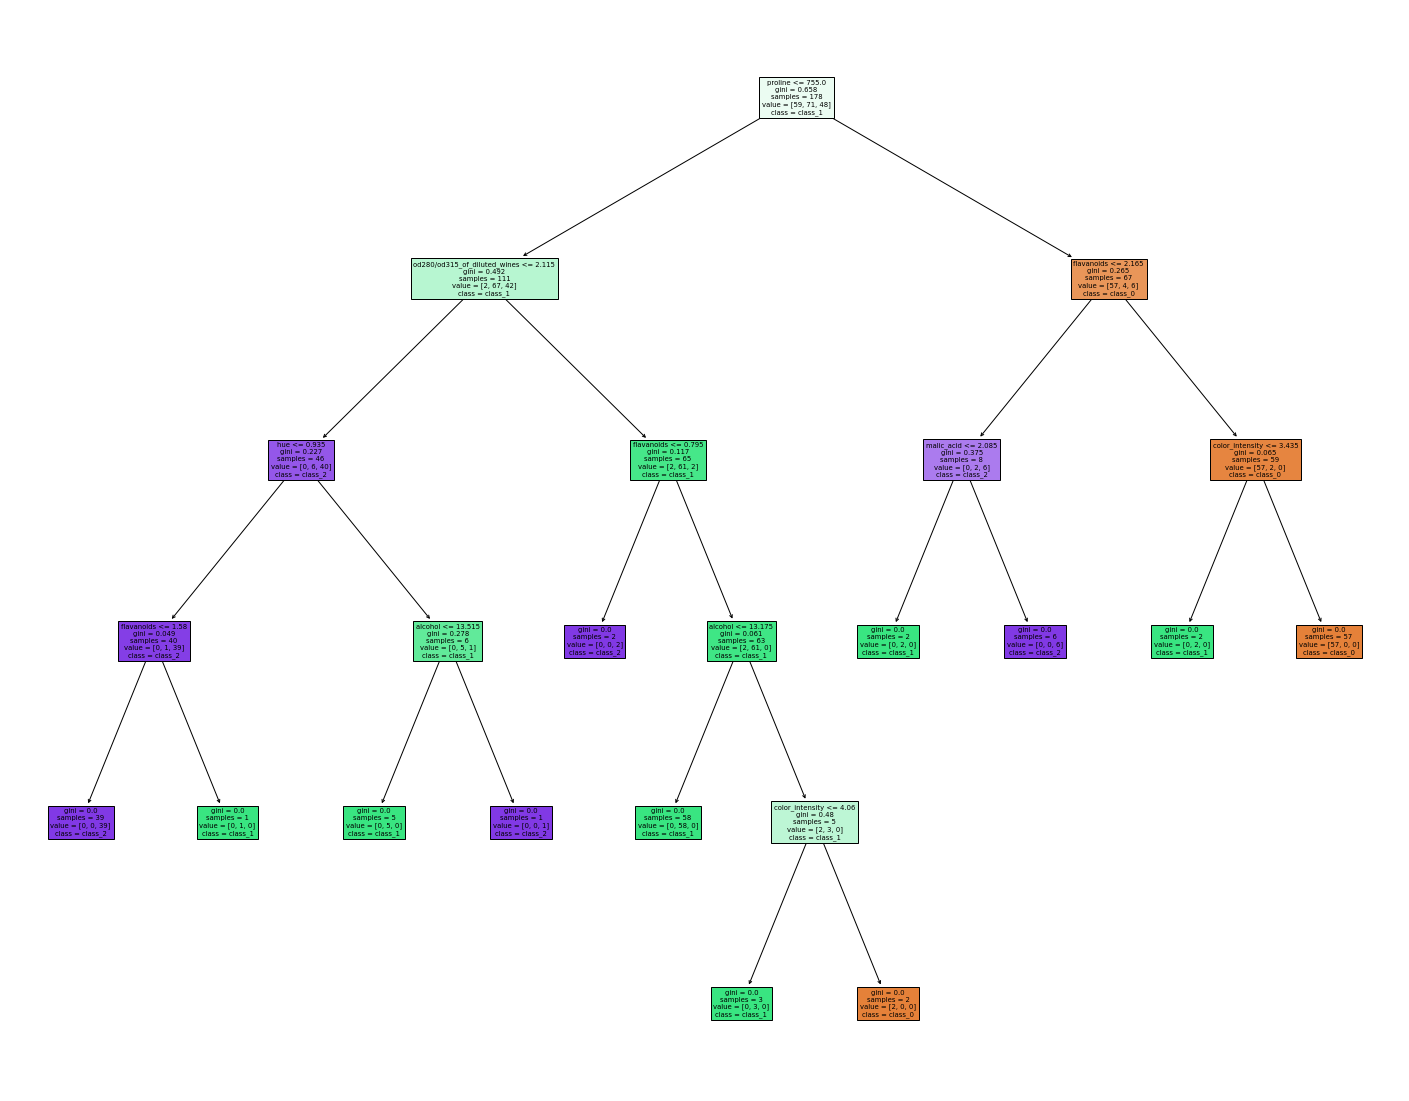

In [13]:
from sklearn import tree
from IPython.display import SVG
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc_wine, feature_names=wine.feature_names, class_names=wine.target_names, filled=True)
#png_bytes = graph.pipe(format='png')
#SVG(graph.pipe(format='svg'))
# Discuss what the model has learned
# THIS IS SHOWN BELOW

From the dataset, it seems to me that the decision tree learned that it first needed to split the data based upon the proline level of the wine. And it seems to me that the flavanoids that are in the wine is one of the last features to be split into pure nodes. I was surprised to see that alcohol level wasn't more deterministic on classification.

## 6. (optional 5% extra credit) Implement reduced error pruning to help avoid overfitting.  
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).